In [1]:
import numpy as np
import pandas as pd
from pandas_datareader import data as pdr
import fix_yahoo_finance as yf
import matplotlib.pyplot as plt

yf.pdr_override()

With this notebook, I want to study past market data for backtesting purposes, without relying on my insights to predict future price movements. I will be using the index Standard & Poor 500(S&P 500), which is considered a good indicator of market performance, because of the names included in this list. It also provides highly liquid futures and options markets.

We will start by getting the data to be be read and implement a basic backtesting for a trading system based on trend signals.

In [2]:
# Standard & Poor 500 index stock prices
tickers = ['^GSPC']

start_date = '2005-07-24'
end_date = '2019-05-13'

# User pandas_reader.data.DataReader to load the desired data. As simple as that.
sp500 = pdr.get_data_yahoo(tickers,start=start_date, end=end_date)
sp500.info()


[*********************100%***********************]  1 of 1 downloaded
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3473 entries, 2005-07-25 to 2019-05-10
Data columns (total 6 columns):
Open         3473 non-null float64
High         3473 non-null float64
Low          3473 non-null float64
Close        3473 non-null float64
Adj Close    3473 non-null float64
Volume       3473 non-null int64
dtypes: float64(5), int64(1)
memory usage: 189.9 KB


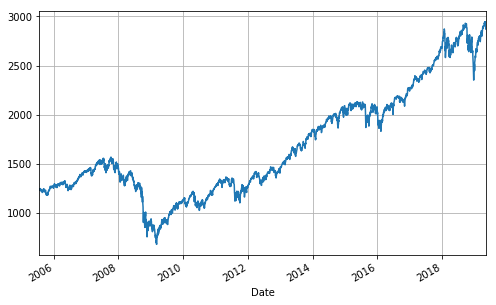

In [3]:
sp500['Close'].plot(grid=True, figsize=(8,5))

In the plot above we can visualise a time series data('Closing Prices') for the S&P 500 index from 2005-07-24 until 2019-05-13.

I want to implement a trend strategy based on a month (21 days) and 6 months (126 days).

In [4]:
# Moving Averages for 2 months(42 days) & a year(252 days)

sp500['21d'] = np.round(sp500['Close'].rolling(21).mean(), 2)

sp500['126d'] = np.round(sp500['Close'].rolling(126).mean(), 2)

In [5]:
sp500[['Close', '21d', '126d']].tail()

,Close,21d,126d
Date,,,
2019-05-06,2932.47,2914.85,2735.29
2019-05-07,2884.05,2914.44,2736.44
2019-05-08,2879.42,2913.66,2737.68
2019-05-09,2870.72,2913.31,2738.73
2019-05-10,2881.40,2912.98,2739.73


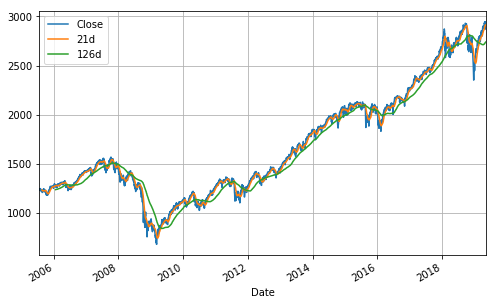

In [6]:
sp500[['Close', '21d', '126d']].plot(grid = True, figsize=(8,5))

The plot above provides us with insights regarding upward/  downward trends that occurred in the past. This will be used to forecast future stock prices fluctuations and assist us in the decision-making process regarding:
    Buying
    Waiting
    Selling
    
    
The rule to generate trading signals are as follows:

Buy Signal( "Go Long" )
    The 21d trend is for the first time SD points above the 126d trend
    
Wait( "Park In Cash" )
    The 21d trend is within a range of +/- SD points around the 126d trend
    
Sell Signal(" Go Short" )
    The 21d trend is for the first time below the 126d trend
    
    
To make this work, I need to add an extra column to my DataFrame with the differences between the two trends

In [7]:
sp500['21d - 126d'] = sp500['21d'] - sp500['126d']
sp500['21d - 126d'].tail()

Date
2019-05-06    179.56
2019-05-07    178.00
2019-05-08    175.98
2019-05-09    174.58
2019-05-10    173.25
Name: 21d - 126d, dtype: float64

The newly created column with the differences between the two moving averages contains NaNs for the first rows. This is because the two columns are mismatched

In [8]:
sp500['21d - 126d'].head()

Date
2005-07-25   NaN
2005-07-26   NaN
2005-07-27   NaN
2005-07-28   NaN
2005-07-29   NaN
Name: 21d - 126d, dtype: float64

Next, I will generate a new column called regime. I will assume the value of 30 for the signal threshold(SD).

In [9]:
SD = 30
sp500['Regime'] = np.where(sp500['21d - 126d'] > SD, 1, 0)                      # Positive
sp500['Regime'] = np.where(sp500['21d - 126d'] < SD, -1, sp500['Regime'])        # Negative
sp500['Regime'].value_counts()


 1    1983
-1    1365
 0     125
Name: Regime, dtype: int64

To summarise the results above,on 1983 trading days, the 21d trend lies more than SD points above the 126d trend. On 1365 trading days, the 21d trend is more than SD points below the 126d trend.
If the the short-term trend crosses the line of the long-term trend it tends to rest there for a longer period. This is called the regime. I will illustrate it plotting it below

(-1.1, 1.1)

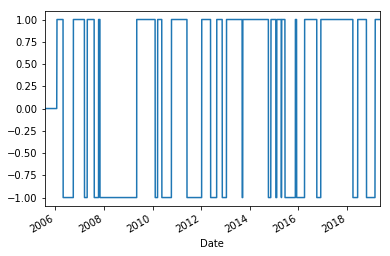

In [10]:
sp500['Regime'].plot(lw = 1.5)
plt.ylim([-1.1,1.1])

The testing of the investment strategy based on the signals is based on the simplistic view that the investor can directly invest/short the index. This is can only be done in the real world by using index funds, exchange-traded funds, or futures on the index. All of which incurr transaction costs ( disregarded in this NB).

Following the regime above, an investor is either long or short in the market(SP500 index) or parks his/her wealth in cash without any interest gains. The main focus will be on the market returns.

The investor makes market returns when he is long(1), makes negative market returns when he is short(-1) and makes no returns(0) when the wealth is parked in cash.

So, next step will be to calculate the market retuns. More specifically,the daily log returns.

In [11]:
sp500['Market'] = np.log(sp500['Close'] / sp500['Close'].shift(1))

In order to get the returns of the trend based strategy, I will have to multiply the Regime column(shifted by one day) by the Returns column. In other words,"yesterday's position yields today's returns".

In [12]:
sp500['Strategy'] = sp500['Regime'].shift(1) * sp500['Market']

The next step is compare the cumulative continuous returns of the index against the cumulative continuous returns of the strategy. 

A plot will probably be the best tool for this task.

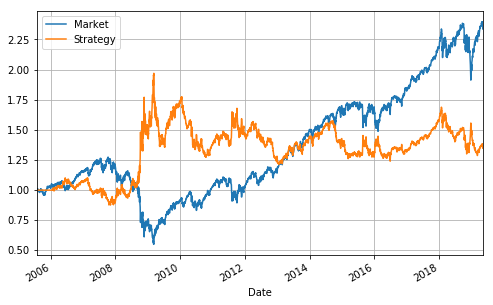

In [13]:
sp500[['Market', 'Strategy']].cumsum().apply(np.exp).plot(grid=True, figsize=(8,5))

The plot above captures the significantly high returns from shorting the market during the economic downturn (2008/2009). And a market recovery point (2013), where the index outperforms our strategy